# Analysis of Citibike trips by user demographics

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# import our helpers module. appending parent directory ("..") to sys.path might be necessary for helpers to be imported on some systems
import sys

sys.path.insert(0, "..")
import helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data
* trips

In [ ]:
DATA_DIR = "../data/"
TRIPDATA_YEAR = 2019

In [ ]:
%%time
trips = helpers.get_trips(TRIPDATA_YEAR, DATA_DIR)
trips["starttime"] = pd.to_datetime(trips["starttime"])
trips["stoptime"] = pd.to_datetime(trips["stoptime"])
trips

CPU times: user 40.8 s, sys: 28.3 s, total: 1min 9s
Wall time: 1min 10s


,tripduration,starttime,stoptime,startstationid,endstationid,bikeid,usertype,birthyear,gender
0,320,2019-01-01 00:01:47.401,2019-01-01 00:07:07.581,3160,3283,15839,Subscriber,1971,1
1,316,2019-01-01 00:04:43.736,2019-01-01 00:10:00.608,519,518,32723,Subscriber,1964,1
2,591,2019-01-01 00:06:03.997,2019-01-01 00:15:55.438,3171,3154,27451,Subscriber,1987,1
3,2719,2019-01-01 00:07:03.545,2019-01-01 00:52:22.650,504,3709,21579,Subscriber,1990,1
4,303,2019-01-01 00:07:35.945,2019-01-01 00:12:39.502,229,503,35379,Subscriber,1979,1
...,...,...,...,...,...,...,...,...,...
20551512,729,2019-10-31 23:59:12.190,2019-11-01 00:11:21.486,237,311,25725,Subscriber,1995,1
20551513,645,2019-10-31 23:59:17.047,2019-11-01 00:10:02.945,3259,461,39583,Customer,1969,0
20551514,257,2019-10-31 23:59:22.514,2019-11-01 00:03:40.260,3798,505,21240,Subscriber,1985,1
20551515,466,2019-10-31 23:59:23.171,2019-11-01 00:07:09.205,328,361,34916,Subscriber,1989,0


## Demographics EDA

In [ ]:
# set type to datetime for below graphs
trips["birthyear"] = pd.to_datetime(trips["birthyear"], format="%Y")

In [ ]:
trips_by_birthyear = (
    trips.groupby(trips["birthyear"].dt.year)["tripduration"]
    .count()
    .reset_index()
    .rename(columns={"tripduration": "countbirthyear"})
)
trips_by_birthyear

,birthyear,countbirthyear
0,1857,6
1,1863,2
2,1874,5
3,1880,1
4,1885,269
...,...,...
113,1999,161942
114,2000,124094
115,2001,62450
116,2002,27084


In [ ]:
subscriber_trips_by_birthyear = (
    trips[trips["usertype"] == "Subscriber"]
    .groupby(trips["birthyear"].dt.year)["tripduration"]
    .count()
    .reset_index()
    .rename(columns={"tripduration": "countbirthyear"})
)
subscriber_trips_by_birthyear

,birthyear,countbirthyear
0,1874,5
1,1885,260
2,1886,286
3,1887,274
4,1888,1083
...,...,...
105,1999,117206
106,2000,81998
107,2001,41004
108,2002,15082


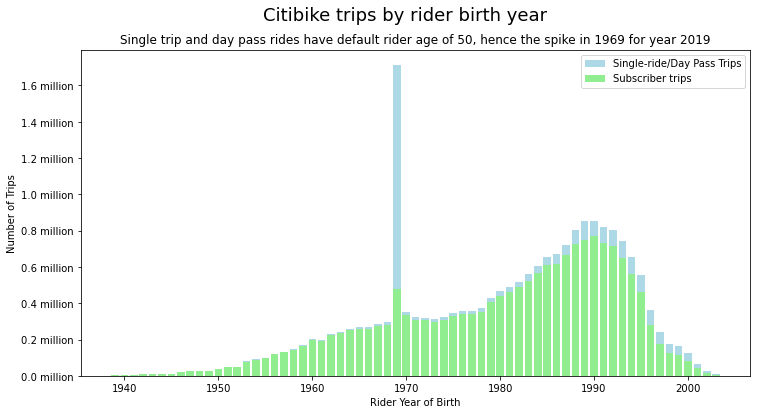

In [ ]:
# lot of 1969 births??? these are riders with usertype=customer with default age 50!
birthyear_floor = TRIPDATA_YEAR - 80
customer_spike_year = TRIPDATA_YEAR - 50
birthyears_to_plot = trips_by_birthyear[
    trips_by_birthyear["birthyear"] >= birthyear_floor
]
subscriber_birthyears_to_plot = subscriber_trips_by_birthyear[
    subscriber_trips_by_birthyear["birthyear"] >= birthyear_floor
]

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

ax.bar(
    data=birthyears_to_plot,
    x="birthyear",
    height="countbirthyear",
    color="lightblue",
    label="Single-ride/Day Pass Trips",
)
ax.bar(
    data=subscriber_birthyears_to_plot,
    x="birthyear",
    height="countbirthyear",
    color="lightgreen",
    label="Subscriber trips",
)
ax.legend()
plt.suptitle("Citibike trips by rider birth year", fontsize=18)
plt.title(
    f"Single trip and day pass rides have default rider age of 50, hence the spike in {customer_spike_year} for year {TRIPDATA_YEAR}"
)

# format birthyear x tick labels
plt.locator_params(axis="x", nbins=10)
plt.xlabel("Rider Year of Birth")

ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: ("%1.1f million" % (x * 1e-6)))
)
plt.ylabel("Number of Trips")

plt.show()

In [ ]:
# reset type back to int for below graphs
trips["birthyear"] = trips["birthyear"].dt.year

In [ ]:
# by age. we see most riders are between 20 and 50 years
ages = trips[["birthyear", "gender"]]
ages["age"] = TRIPDATA_YEAR - ages["birthyear"]
age_bins = [0, 20, 30, 40, 50, 60, 70, 1000]
age_labels = ["<20", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"]
ages["agerange"] = pd.cut(
    ages.age, bins=age_bins, labels=age_labels, include_lowest=True
)

ageranges = (
    ages.drop("birthyear", axis=1)
    .groupby(["agerange", "gender"])
    .agg("sum")
    .reset_index()
    .rename(columns={"age": "count"})
)
ageranges["gender"] = ageranges["gender"].replace(
    {1: "male", 2: "female", 0: "unknown"}
)
ageranges = ageranges[ageranges["gender"] != "unknown"]

/var/folders/zx/f3rt3pyx58xg7vm_jv6_g3jh0000gn/T/ipykernel_95179/662681817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages["age"] = TRIPDATA_YEAR - ages["birthyear"]
/var/folders/zx/f3rt3pyx58xg7vm_jv6_g3jh0000gn/T/ipykernel_95179/662681817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages["agerange"] = pd.cut(


/opt/anaconda3/envs/python310/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


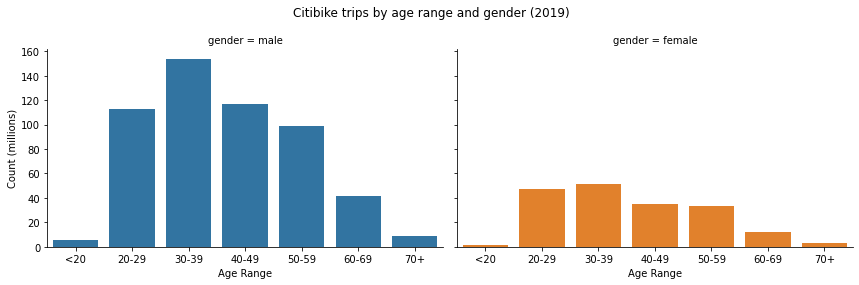

In [ ]:
# plot riders by age and gender
g = sns.FacetGrid(
    ageranges, col="gender", hue="gender", height=4, aspect=1.5, sharey=True
)
g.map(sns.barplot, "agerange", "count")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"Citibike trips by age range and gender ({TRIPDATA_YEAR})")
g.tight_layout()
plt.ticklabel_format(style="plain", axis="y")
g.set_axis_labels("Age Range", "Count (millions)")
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: ("%1.f" % (x * 1e-6))))
plt.show()

# Remove from memory
del ages, ageranges, age_bins, age_labels

In [ ]:
# gender counts
genders = trips[["gender"]].value_counts().reset_index().rename(columns={0: "count"})
genders["gender"] = genders["gender"].replace({1: "Male", 2: "Female", 0: "Unknown"})
genders["percent"] = trips["gender"].value_counts(normalize=True).round(4).mul(100)
genders

,gender,count,percent
0,Male,14052230,7.59
1,Female,4938982,68.38
2,Unknown,1560305,24.03


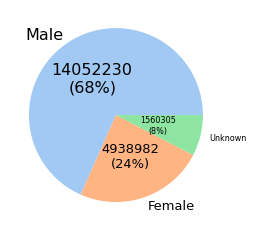

In [ ]:
# pie chart!
def autopct_format(values):
    def _(pct):
        total = sum(values)
        percent = int(round(pct * total / 100.0))
        return "{v:d}\n({:.0f}%)".format(pct, v=percent)

    return _


_, ax = plt.subplots()
_, labels, autopct = ax.pie(
    data=genders,
    x="count",
    labels="gender",
    colors=sns.color_palette("pastel"),
    autopct=autopct_format(genders["count"]),
    pctdistance=0.5,
)
autopct[0].set_fontsize(16)
autopct[1].set_fontsize(13)
autopct[2].set_fontsize(8)
labels[0].set_fontsize(16)
labels[1].set_fontsize(13)
labels[2].set_fontsize(8)

ax.set_aspect("equal")
plt.show()

# del genders

In [ ]:
# by user type
usertype = pd.concat(
    [
        trips["usertype"].value_counts().rename("count"),
        trips["usertype"]
        .value_counts(normalize=True)
        .round(4)
        .mul(100)
        .rename("percent"),
    ],
    axis=1,
)
usertype.index = ["Subscriber\nTrips", "Single Ride or\nDay Pass\nTrips"]
usertype

,count,percent
Subscriber\nTrips,17679393,86.02
Single Ride or\nDay Pass\nTrips,2872124,13.98


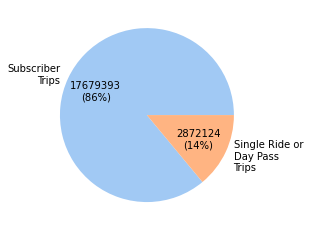

In [ ]:
def autopct_format(values):
    def _(pct):
        total = sum(values)
        percent = int(round(pct * total / 100.0))
        return "{v:d}\n({:.0f}%)".format(pct, v=percent)

    return _


_, ax = plt.subplots()
_, labels, autopct = ax.pie(
    data=usertype,
    x="count",
    labels=usertype.index,
    colors=sns.color_palette("pastel"),
    autopct=autopct_format(usertype["count"]),
    pctdistance=0.65,
)

ax.set_aspect("equal")
plt.show()

del usertype